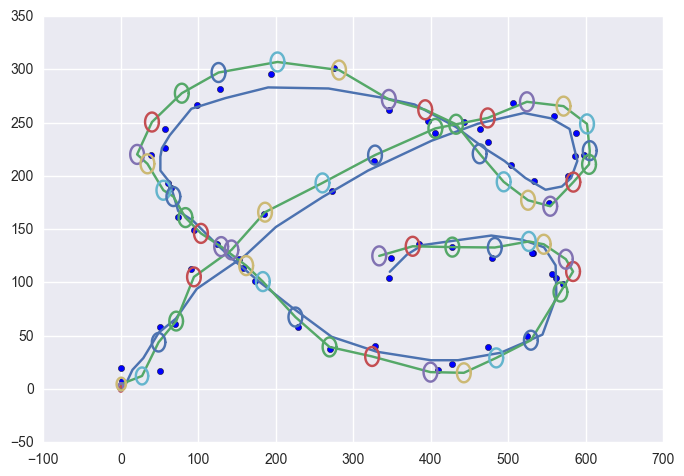

In [1]:
import numpy as np
import scipy.io
import skimage.feature
import matplotlib
import matplotlib.pyplot as plt
import seaborn

# Takes the covariance and gives back points to create an ellipse 
# around the 95% confidence interval
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )


kfdata_mat = scipy.io.loadmat('kfdata.mat')
kfdata = kfdata_mat['data']
kf_truedata = kfdata_mat['true_data']

# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])

 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
#Rsecond = 1000*np.eye(2)
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )    

#create arrays
sigma = []
mu = []
firstsig =  sigma_t.tolist()

#give them their first indecies
sigma.append(firstsig)
mu.append(mu_t)

# Solve for the rest of the equations
for t in xrange(1,kfdata.shape[0]):
    sigpri = np.dot(A, np.dot(sigma[t-1], A.T))+ Q
    st = np.dot(C, np.dot(sigpri, C.T))+R
    kt = np.dot(sigpri, np.dot(C.T, np.linalg.pinv(st)))
    yhat = np.dot(C,np.dot(A,mu[t-1]))
    data =  kfdata[t-1].reshape((2,1))
    difference = data-yhat
    muval = np.dot(A,mu[t-1]) + np.dot(kt, difference)
    mu.append(muval)
    sigma.append((np.dot(np.identity(len(kt)) - np.dot(kt, C), sigpri)))


plt.figure()
plt.clf()
x = []
y = []
for m in mu:
    x.append(m[0,0])
    y.append(m[1,0])

plt.plot( kf_truedata[:,0], kf_truedata[:,1])
plt.scatter(kfdata[:,0], kfdata[:,1])
plt.plot( x, y)

i = 0
for s in sigma:
    sigma_i = np.asarray(s)
    cov = cov_to_pts(sigma_i[:2,:2])
    plt.plot(cov[0]+mu[i][0,0], cov[1]+mu[i][1,0])
    i+=1


plt.show()
    


In [2]:
def sigmamu(sigma, mu, y):
    sigpri = np.dot(A, np.dot(sigma, A.T))+ Q
    st = np.dot(C, np.dot(sigpri, C.T))+R
    kt = np.dot(sigpri, np.dot(C.T, np.linalg.pinv(st)))
    yhat = np.dot(C,np.dot(A,mu))
    difference = y.reshape((2,1))-yhat
    newmu = np.dot(A,mu) + np.dot(kt, difference)
    newsigma =(np.dot(np.identity(len(kt)) - np.dot(kt, C), sigpri))
    return newmu, newsigma

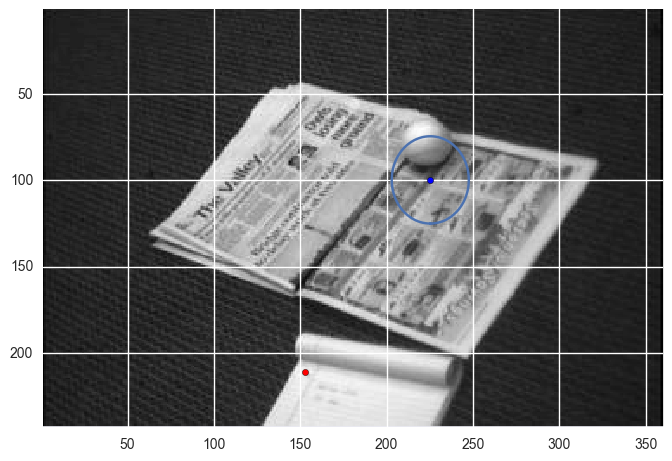

In [3]:
import time 
from IPython import display
# our dynamics are described by random accelerations
# it's changed so it's moving more in the x and accelerating more in x
#it's x y x' y' x'' y'' so
# x:x, x:y, x:x', x:y', x:x'', x:y''
# -, y:y, y:x', y:y', y:x'', y:y''
#-,-,x':x', x':y', x':x'', x':y''
#-,-,-,y':y', y':x'', y':y''
#-,-,-,-,x'':x'', x'': y''
#-,-,-,-,-y'':y''
#as x and y are independent those don't change the others.
# however the position, velocity and acceleration are all correlated
A = np.asarray([
    [ 1, 0, .7, 0, .5, 0],
    [ 0, 1, 0, .7, 0, .5 ],
    [ 0, 0, 1, 0, .5, 0 ],
    [ 0, 0, 0, 1, 0, .5 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])

# it's moving more in the x, so we get a mean observation of half 
# a change in x and a cahnge in y
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, .9, 0, 0, 0, 0]])

 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty. We get more of this in Y than x
Q = 1e-2 * np.eye( 6 )
Q[4,4] = .6  # variance of accelerations is higher
Q[5,5] = 1  # in the y it's slower acceleration than x
 
# our observation noise, we're pretty unsure about our data. so make it large
R = 200 * np.eye( 2 )
 
# initial state, assume it's the identity matrix. We'll figure the rest out later
sigma_t = np.eye( 6 )  

tmp = scipy.io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template


data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results

data = np.asarray( data )

# assumes that "mus" contains a list of Gaussian means, and that "covs" is a list of Gaussian covariances

mus_1 = []
muball = np.zeros(( 6, 1 ))


#set initial x and y
muball[0] = data[0,0]
muball[1] = data[0,1]
mus_1.append(muball)
covs = []
covs.append(firstsig)
for t in xrange(1,data.shape[0]):
    mu_tocpy, covs_tocpy = sigmamu(covs[t-1], mus_1[t-1], data[t-1])
    covs.append(covs_tocpy)
    mus_1.append(mu_tocpy)


o = []
n = []
for m in mus_1:
    o.append(m[0,0])
    n.append(m[1,0])



# assumes that "mus" contains a list of Gaussian means, and that "covs" is a list of Gaussian covariances
 
for t in range(0, data.shape[0]):
 
    tmp = np.reshape( frames[:,t], (360,243) ).T
 
    plt.figure(1)
    plt.clf()
    plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    plt.scatter( data[t][1], data[t][0] , c = 'Red')
    plt.scatter( mus_1[t][1], mus_1[t][0] )
    covs_t = np.asarray(covs[t])
    foo = cov_to_pts( covs_t[0:2,0:2] )
 
    plt.plot( foo[0,:] + mus_1[t][1], foo[1,:] + mus_1[t][0] )
    plt.xlim([1, 360])
    plt.ylim([243,1])
 
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.3)
    

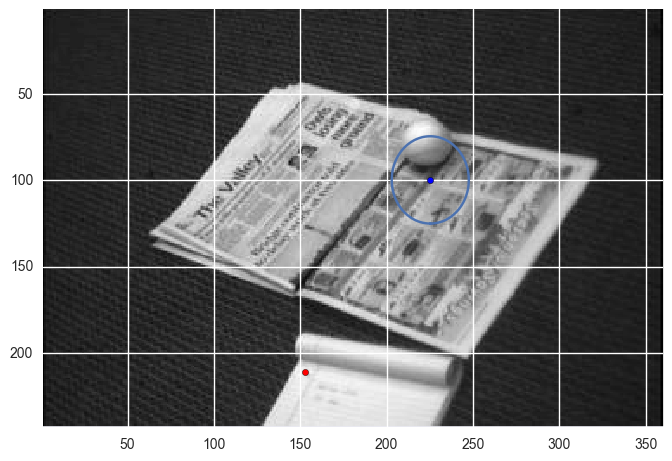

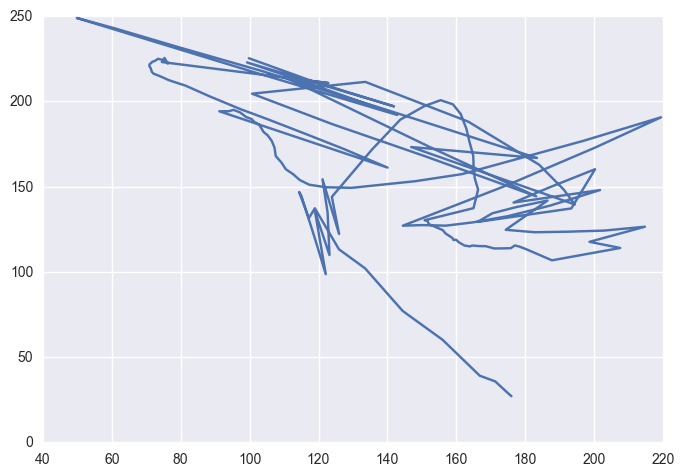

In [4]:
plt.figure(2)
plt.clf()
plt.plot(o, n)
plt.show()

